In [1]:
%load_ext autoreload
%autoreload 2
from dolfinx import fem, mesh, plot
from dolfinx.io import gmshio
from mpi4py import MPI
import ufl
from petsc4py import PETSc
from slepc4py import SLEPc
import numpy as np
from dolfinx.io import XDMFFile
import matplotlib.pyplot as plt
from scipy.linalg import null_space
from dolfinx_utils import *
from helmholtz_x.passive_flame_x import *
from helmholtz_x.eigensolvers_x import pep_solver, eps_solver
from helmholtz_x.eigenvectors_x import normalize_eigenvector, normalize_unit, normalize_adjoint
from helmholtz_x.dolfinx_utils import XDMFReader, xdmf_writer 
from helmholtz_x.shape_derivatives_x import _shape_gradient_Robin
from helmholtz_x.shape_derivatives import ShapeDerivatives
# from helmholtz_x.petsc4py_utils import conjugate_function
import pyvista
%autoreload utils.dolfin_utils

In [2]:
def conjugate_function(p, msh, degree):
    V = fem.FunctionSpace(msh, ("Lagrange", degree))
    p_conj = fem.Function(V)
    p_conj.vector[:] = np.conjugate(p.vector[:])

    return p_conj

In [3]:
def normalize_robin_vectors(omega, A, B, C, p, p_adj, R, c, msh, degree):
    L_dash = B + (2*omega)*C
    # L_dash = (2*omega)*C
    V = fem.FunctionSpace(msh, ("Lagrange", degree))
    Lp = fem.Function(V)
    L_dash.mult(p.vector, Lp.vector)

    p_conj = conjugate_function(p_adj, msh, degree)
    Lp = conjugate_function(Lp, msh, degree)

    first_term_val = p_conj.vector.dot(Lp.vector)
    print(first_term_val)

    # first_term = fem.form(ufl.inner(p_adj, Lp)*ufl.dx)
    # first_term_val = fem.assemble_scalar(first_term)

    Z = (1+R)/(1-R)
    # Z=1
    second_term = fem.form((1j*c/Z) * ufl.inner(p_adj, p)*ufl.ds)
    second_term_val = fem.assemble_scalar(second_term)

    norm_const = first_term_val + second_term_val

    # p.vector[:] = p.vector[:]/np.sqrt(norm_const)
    # p_adj.vector[:] = p_adj.vector[:]/np.sqrt(norm_const)
    print(norm_const)
    # norm_const = 4.955964069450003+1.1212577669710847e-10j
    p_adj.vector[:] = p_adj.vector[:]/np.conjugate(norm_const)

    # print(norm_const)
    return [p, p_adj]

In [4]:
def normalize_robin_vectors(omega, A, B, C, p, p_adj, R, c, msh, degree):
    # L_dash = B + (2*omega)*C
    # # L_dash = (2*omega)*C
    # V = fem.FunctionSpace(msh, ("Lagrange", degree))
    # Lp = fem.Function(V)
    # L_dash.mult(p.vector, Lp.vector)

    # p_conj = conjugate_function(p_adj, msh, degree)
    # Lp = conjugate_function(Lp, msh, degree)

    # first_term_val = p_conj.vector.dot(Lp.vector)
    # print(first_term_val)

    V = fem.FunctionSpace(msh, ("Lagrange", degree))
    Lp = fem.Function(V)
    B.mult(p.vector, Lp.vector)
    Lp.vector[:] = (2*omega)*p.vector[:]

    first_term = fem.form(ufl.inner(Lp, p_adj)*ufl.dx)
    first_term_val = fem.assemble_scalar(first_term)


    Z = (1+R)/(1-R)
    # Z=1
    second_term = fem.form((1j*c/Z) * ufl.inner(p, p_adj)*ufl.ds)
    second_term_val = fem.assemble_scalar(second_term)

    norm_const = first_term_val #+ second_term_val
    print(second_term_val)

    # p_adj.vector[:] = p_adj.vector[:]/(np.sqrt(norm_const)*np.conjugate(np.sqrt(norm_const)))
    # p_adj.vector[:] = p_adj.vector[:]/np.conjugate(norm_const)
    p_adj.vector[:] = p_adj.vector[:]/np.conjugate(norm_const)
    p_conj = conjugate_function(p_adj, msh, degree)

    print((p_conj.vector.dot(Lp.vector) + fem.assemble_scalar(fem.form((1j*c/Z) * ufl.inner(p, p_adj)*ufl.ds))))
    
    return [p, p_adj]

In [5]:
def find_eigenvalue(epsilon, degree):
    N = 100
    degree = degree
    c_const = 1 #np.sqrt(5)
    R = -0.9999999999
    msh = mesh.create_rectangle(MPI.COMM_WORLD, [[0, -epsilon], [1, 1]], [N, N])
    c = fem.Constant(msh, PETSc.ScalarType(c_const))

    boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], 1)),
              (3, lambda x: np.isclose(x[1], -epsilon)),
              (4, lambda x: np.isclose(x[1], 1))]
    
    ds, facet_tags = tag_boundaries(msh, boundaries=boundaries, return_tags=True)

    boundary_conditions = {4: {'Robin': R},
                        3: {'Robin': R},
                        2: {'Robin': R},
                        1: {'Robin': R}}

    matrices = PassiveFlame(msh, facet_tags, boundary_conditions, c , degree = degree)

    matrices.assemble_A()
    matrices.assemble_B()
    matrices.assemble_C()

    A = matrices.A
    B = matrices.B
    C = matrices.C

    # i=0
    # omega = 0
    # while abs(omega.real - 9.9) > 0.05:
    #     target =  np.pi*c_const/(1 + 0.01*i)
    #     E = pep_solver(A, B, C, target**2, nev = 2)
    #     omega, p = normalize_eigenvector(msh, E, 0, degree=degree, which='right')
    #     omega_adj, p_adj = normalize_eigenvector(msh, E, 0, degree=degree, which='left')
        # i += 1

    target =  np.pi*c_const*0.7
    E = pep_solver(A, B, C, target**2, nev = 2)
    omega, p = normalize_eigenvector(msh, E, 0, degree=degree, which='right')
    omega_adj, p_adj = normalize_eigenvector(msh, E, 0, degree=degree, which='left')

    assert np.isclose(omega, omega_adj)

    p = normalize_magnitude(p, imaginary=True)
    p_adj = normalize_magnitude(p_adj, imaginary=True)
    
    normalize_robin_vectors(omega, A, B, C, p, p_adj, R, c, msh, degree)

    return [omega, p, p_adj, msh, ds, c, facet_tags]

In [6]:
def find_shapegrad_dirichlet(geometry, omega, p, p_adj, ds, c, degree):
    # dp_dn = ufl.Dn(p)
    # G = _shape_gradient_Robin(geometry, c, omega, p, conjugate_function(p_adj), 3)
    V = fem.FunctionSpace(geometry.mesh, ("Lagrange", degree))
    p_adj = conjugate_function(p_adj, geometry.mesh, degree)
    G = - p_adj * (c*ufl.Dn(c))*ufl.Dn(p) + ufl.div(p_adj*(c**2)*ufl.grad(p)) - 2*ufl.Dn(p_adj)*(c**2)*ufl.Dn(p)
    
    # t = fem.Function(V)
    # expr = fem.Expression(G)
    # t.interpolate(expr)
    # plotp(t, geometry.mesh, degre, 1)
    # shape_der = ShapeDerivatives(geometry, [], p, p_adj, c)
    # shape_der.curvature = 0
    # G = shape_der.get_Robin()

    C = 1
    dw = fem.assemble_scalar(fem.form(C* G*ds(3)))

    return dw

In [7]:
class Geometry:
    def __init__(self, msh, facet_tags):
        self.mesh = msh
        self.facet_tags = facet_tags
    
    def get_curvature_field(self, index):
        return 0

\/ Speed of sound function is used for passive flame matrices.
- Passive matrices are assembling..
- Matrix A is assembled.
- Matrix B is assembled.
- Matrix C is assembled.

- PEP solver started.
- PEP solver converged. Eigenvalue computed.
Eigenvalue-> 4.443431-0.000000j

Frequency -> 0.707194 (1/s) | Growth Rate -> -0.000000 (rad/s) 

Eigenvalue-> 4.443431-0.000000j

Frequency -> 0.707194 (1/s) | Growth Rate -> -0.000000 (rad/s) 

5.00125705782217e-11j
(10003.293500223996+3.1463615047426813e-08j)
(-2.2211680987137448-5.693367881757342e-11j)
\/ Speed of sound function is used for passive flame matrices.
- Passive matrices are assembling..
- Matrix A is assembled.
- Matrix B is assembled.
- Matrix C is assembled.

- PEP solver started.
- PEP solver converged. Eigenvalue computed.
Eigenvalue-> 4.443431-0.000000j

Frequency -> 0.707194 (1/s) | Growth Rate -> -0.000000 (rad/s) 

Eigenvalue-> 4.443431-0.000000j

Frequency -> 0.707194 (1/s) | Growth Rate -> -0.000000 (rad/s) 

5.0012570578

Text(0, 0.5, '$|\\delta_{FD} - \\delta_{AD}|$')

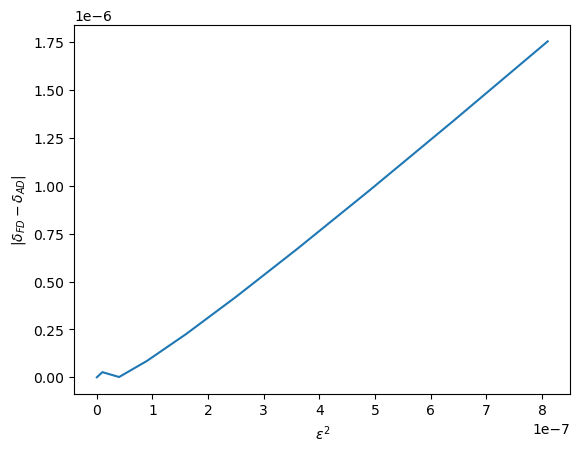

In [14]:
degree = 2
omega, p, p_adj, msh, ds, c, facet_tags = find_eigenvalue(0, degree)
geometry = Geometry(msh, facet_tags)
dw = find_shapegrad_dirichlet(geometry, omega, p, p_adj, ds, c, degree)
print(dw)

x_points = []
y_points = []

for i in range(10):
    epsilon = 0.0001*i
    omega_new = find_eigenvalue(epsilon, degree)[0]
    Delta_w_FD = omega_new.real - omega.real
    x_points.append(epsilon**2)
    y_points.append(abs(Delta_w_FD - dw*epsilon))

plt.plot(x_points, y_points)
plt.xlabel('$\epsilon^2$')
plt.ylabel('$|\delta_{FD} - \delta_{AD}|$')

In [9]:
-2.221989392667208+5.124786931454251e-11j

(-2.221989392667208+5.124786931454251e-11j)

In [10]:
(4.955964069450003+1.1212577669710847e-10j)
(4.955964069450003+1.1212577670318335e-10j)
(-4.960471095574255+1.1222774552251325e-10j)

(-4.960471095574255+1.1222774552251325e-10j)

In [11]:
def plotp(p, msh, degree, boundary=1, mesh=False):
    point = {
        1: [(0, 0, 0), (1, 0, 0)],
        2: [(0, 0, 0), (0, 1, 0)],
        3: [(0, 0.99, 0), (1, 0.99, 0)],
        4: [(1, 0, 0), (1, 1, 0)]
    }
    V = fem.FunctionSpace(msh, ("Lagrange", degree))
    plotter = pyvista.Plotter()
    
    topology, cell_types, geometry = plot.create_vtk_mesh(msh, msh.topology.dim)
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    plotter.add_mesh(grid, show_edges=True)

    u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)
    u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)

    u_grid.point_data["p"] = p.x.array.real
    u_grid.set_active_scalars("p")
    plotter.add_mesh(u_grid, show_edges=True)
    x_line = np.linspace(0, 1, 100)
    p_sim = u_grid.sample_over_line(*point[boundary], resolution=99).point_data["p"]
    # p_act = np.sqrt(2)*np.pi*np.sin(np.pi*x_line)**2
    # p_act = -np.pi*np.sin(np.pi*x_line)
    # plt.plot(x_line, p_act, label="Analytical")
    if not mesh:
        plt.plot(x_line, p_sim, label="Numerical")
        plt.legend()
    else:
        plotter.view_xy()
        plotter.show()
    # return p_sim